In [10]:
import SimpleITK as sitk

import itk
import guiPoint

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from scipy import linalg

from ipywidgets import interact, fixed
from __future__ import print_function

import sys
from myshow import myshow, myshow3d

import numpy as np
from scipy import linalg
from importlib import reload

from ipywidgets import interact, fixed
from IPython.display import clear_output

Please enter name of images to import.

In [11]:
threeD_image = sitk.ReadImage("5342_3D_8_51519.mha")
#threeD_image_r = sitk.ReadImage("5342_3D_8_51519_resampled.mha")
T1_image = sitk.ReadImage("5342_T1_9_68083.mha")
T2_image = sitk.ReadImage("5342_T2_5_16889_resampled.mha")
Flair_image = sitk.ReadImage("5342_Flair_4_19844_resampled.mha")

In [12]:
print(threeD_image.GetPixelIDTypeAsString() )
print(T1_image.GetPixelIDTypeAsString() )
print(T2_image.GetPixelIDTypeAsString() )
print(Flair_image.GetPixelIDTypeAsString() )
print(threeD_image.GetSize())
print(T1_image.GetSize())
print(T2_image.GetSize())
print(Flair_image.GetSize())

16-bit signed integer
16-bit signed integer
64-bit float
64-bit float
(512, 512, 60)
(256, 256, 20)
(256, 256, 20)
(256, 256, 20)


Convert all images from int to float for convenience. 

In [13]:
castFilter = sitk.CastImageFilter()
castFilter.SetOutputPixelType(sitk.sitkFloat64 )
threeD_image = castFilter.Execute(threeD_image)
T1_image = castFilter.Execute(T1_image)
T2_image = castFilter.Execute(T2_image)
Flair_image = castFilter.Execute(Flair_image)

## Seed definition

Please define seeds in the cell below based on output in seed_selection.ipynb

In [75]:
seed_3D = [(319,315,23)]
seeds = [(325, 314, 29), (345, 275, 22), (305, 350, 22)]
seed_T1 = [(171, 152, 8)]
seed_T2 = [(165,135,9)]
seed_Flair = [(154, 170, 9)]
seed_ventricles = [(144,157,11),(116,146,12),(239,83,13)]

## Visualization

In [15]:
myshow(T1_image)
myshow(T2_image)
myshow(Flair_image)
myshow3d(threeD_image)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

## Registration

Note: function below taken from simpleITK notebook sample "60_Registration_Introduction.ipynb"

In [16]:
# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.    
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))        

Registration for threeD_image to move to T1_image

In [17]:
fixed_image =  T1_image
moving_image = threeD_image

interact(display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_image.GetSize()[2]-1), fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));

A Jupyter Widget

In [18]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]), alpha=(0.0,2.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

A Jupyter Widget

In [19]:
interact(display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_resampled.GetSize()[2]-1), fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_resampled)));

A Jupyter Widget

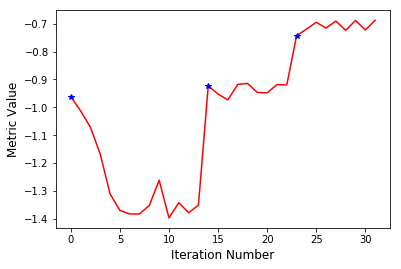

In [20]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform_3D = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                              sitk.Cast(moving_image, sitk.sitkFloat32))

In [21]:
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

Final metric value: -0.7200977517008561
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.


In [22]:
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform_3D, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha, image_z=(0,fixed_image.GetSize()[2]), alpha=(0.0,2.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

A Jupyter Widget

In [23]:
interact(display_images, fixed_image_z=(0,fixed_image.GetSize()[2]-1), moving_image_z=(0,moving_resampled.GetSize()[2]-1), fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_resampled)));

A Jupyter Widget

In [24]:
threeD_image_r = moving_resampled 

In [25]:
#final_transform_3D_inverse = final_transform_3D.GetInverse()
#final_transform_T2_inverse = final_transform_T2.GetInverse()
#final_transform_Flair_inverse = final_transform_Flair.GetInverse()

## Get Anatomical Structure

In [26]:
blurFilter = sitk.CurvatureFlowImageFilter()
blurFilter.SetNumberOfIterations( 3 )
blurFilter.SetTimeStep( 0.15 )
threeD_image_smooth = blurFilter.Execute(threeD_image_r)

myshow(threeD_image_smooth)

A Jupyter Widget

Segment CSF-filled ventricular system using 3D image. 

In [27]:
binaryFilter = sitk.BinaryThresholdImageFilter()
binaryFilter.SetLowerThreshold(-100)
binaryFilter.SetUpperThreshold(50)
threeD_image_water_segment = binaryFilter.Execute(threeD_image_smooth)
myshow(threeD_image_water_segment)

A Jupyter Widget

In [28]:
ThresholdFilter = sitk.ConnectedThresholdImageFilter()
ThresholdFilter.SetSeedList(seed_ventricles)
ThresholdFilter.SetLower(1)
ThresholdFilter.SetUpper(1)
threeD_image_water_segment = ThresholdFilter.Execute(threeD_image_water_segment)
myshow(threeD_image_water_segment)

A Jupyter Widget

In [29]:
closingFilter = sitk.BinaryMorphologicalClosingImageFilter()
closingFilter.SetKernelRadius(3)
threeD_image_water_segment = closingFilter.Execute(threeD_image_water_segment)
myshow(threeD_image_water_segment)

A Jupyter Widget

In [30]:
ThresholdFilter = sitk.ConnectedThresholdImageFilter()
ThresholdFilter.SetSeedList(seed_ventricles)
ThresholdFilter.SetLower(1)
ThresholdFilter.SetUpper(1)
threeD_image_water_segment = ThresholdFilter.Execute(threeD_image_water_segment)
myshow(threeD_image_water_segment)

A Jupyter Widget

In [31]:
dilateFilter= sitk.BinaryDilateImageFilter()
threeD_image_water_segment = dilateFilter.Execute(threeD_image_water_segment)
myshow(threeD_image_water_segment)

A Jupyter Widget

Segment bone using Flair image. 

In [32]:
binaryFilter = sitk.BinaryThresholdImageFilter()
binaryFilter.SetLowerThreshold(1200)
binaryFilter.SetUpperThreshold(1700)
Flair_image_skull_segment = binaryFilter.Execute(Flair_image)
myshow(Flair_image_skull_segment)

A Jupyter Widget

In [33]:
closingFilter = sitk.BinaryMorphologicalClosingImageFilter()
Flair_image_skull_segment = closingFilter.Execute(Flair_image_skull_segment)
myshow(Flair_image_skull_segment)

A Jupyter Widget

In [34]:
dilateFilter= sitk.BinaryDilateImageFilter()
Flair_image_skull_segment = dilateFilter.Execute(Flair_image_skull_segment)
myshow(Flair_image_skull_segment)

A Jupyter Widget

In [35]:
openingFilter = sitk.BinaryMorphologicalOpeningImageFilter()
openingFilter.SetKernelRadius(2)
Flair_image_skull_segment = openingFilter.Execute(Flair_image_skull_segment)
myshow(Flair_image_skull_segment)

A Jupyter Widget

## Remove Anatomical structures

In [36]:
#Obtain mask
binaryFilter = sitk.BinaryThresholdImageFilter()
binaryFilter.SetLowerThreshold(0)
binaryFilter.SetUpperThreshold(0)

threeD_image_water_mask = binaryFilter.Execute(threeD_image_water_segment)
myshow(threeD_image_water_mask)
Flair_image_skull_mask = binaryFilter.Execute(Flair_image_skull_segment)
myshow(Flair_image_skull_mask )


A Jupyter Widget

A Jupyter Widget

In [37]:
#Apply mask filter to all images
maskFilter = sitk.MaskImageFilter()

#T1_image = maskFilter.Execute(T1_image,threeD_image_water_mask)
T2_image = maskFilter.Execute(T2_image,threeD_image_water_mask)
#Flair_image = maskFilter.Execute(Flair_image,threeD_image_water_mask)

T1_image = maskFilter.Execute(T1_image,Flair_image_skull_mask)
T2_image = maskFilter.Execute(T2_image,Flair_image_skull_mask)
Flair_image = maskFilter.Execute(Flair_image,Flair_image_skull_mask)

myshow(T1_image)
myshow(T2_image)
myshow(Flair_image)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

## Segmentation T1

In [38]:
blurFilter = sitk.CurvatureFlowImageFilter()
blurFilter.SetNumberOfIterations( 3 )
blurFilter.SetTimeStep( 0.15 )
T1_image_s = blurFilter.Execute(T1_image)
myshow(T1_image_s) 

A Jupyter Widget

In [39]:
adaptiveFilter = sitk.AdaptiveHistogramEqualizationImageFilter()
adaptiveFilter.SetAlpha(0.5)
adaptiveFilter.SetBeta(1)
T1_image1 = adaptiveFilter.Execute(T1_image_s)
myshow(T1_image1)

A Jupyter Widget

In [40]:
gradientFilter = sitk.GradientMagnitudeRecursiveGaussianImageFilter()
#sigma = sys.argv[3]
#sigma = sigma[1:len(sigma)-1]
gradientFilter.SetSigma(0.8)
T1_image2 = gradientFilter.Execute(T1_image1)
myshow(T1_image2)

A Jupyter Widget

In [41]:
sigmoidFilter = sitk.SigmoidImageFilter()
sigmoidFilter.SetAlpha(-70.0)
sigmoidFilter.SetBeta(60.0)
T1_image3= sigmoidFilter.Execute(T1_image2)
myshow(T1_image3)

A Jupyter Widget

In [42]:
fastFilter = sitk.FastMarchingImageFilter()
#fastFilter.SetTrialPoints(seed_T1)
#fastFilter.SetTrialPoints([(171, 153, 8), (187, 130, 7)])
fastFilter.SetTrialPoints([(186, 131, 7), (170, 154, 8), (168, 154, 9)])
fastFilter.SetStoppingValue(0.15)
T1_image4 = fastFilter.Execute(T1_image3)
myshow(T1_image4)

A Jupyter Widget

In [43]:
binaryFilter = sitk.BinaryThresholdImageFilter()
binaryFilter.SetLowerThreshold(0)
binaryFilter.SetUpperThreshold(10)
T1_image5 = binaryFilter.Execute(T1_image4)
myshow(T1_image5)

A Jupyter Widget

In [44]:
closingFilter = sitk.BinaryMorphologicalClosingImageFilter()
T1_segment = closingFilter.Execute(T1_image5)
myshow(T1_segment)
myshow(T1_image)

A Jupyter Widget

A Jupyter Widget

## Segmentation T2

In [45]:
myshow(T2_image)

A Jupyter Widget

In [46]:
blurFilter = sitk.CurvatureFlowImageFilter()
blurFilter.SetNumberOfIterations( 3 )
blurFilter.SetTimeStep( 0.15 )
T2_image_s = blurFilter.Execute(T2_image)
myshow(T2_image_s) 

A Jupyter Widget

In [78]:
Threshold2Filter = sitk.ConfidenceConnectedImageFilter()
Threshold2Filter.SetInitialNeighborhoodRadius(20)
Threshold2Filter.SetMultiplier(1.1)
Threshold2Filter.SetNumberOfIterations(30)
#Threshold2Filter.SetSeedList ([(166,176,9)])
Threshold2Filter.SetSeedList (seed_T2)
T2_image2= Threshold2Filter.Execute(T2_image)
myshow(T2_image2)

A Jupyter Widget

In [79]:
binaryFilter = sitk.BinaryThresholdImageFilter()
binaryFilter.SetLowerThreshold(0)
binaryFilter.SetUpperThreshold(0)
T2_image3 = binaryFilter.Execute(T2_image2)
myshow(T2_image3 )

A Jupyter Widget

In [99]:
ThresholdFilter = sitk.ConnectedThresholdImageFilter()
ThresholdFilter.SetSeedList([(166,176,9)])
ThresholdFilter.SetLower(1)
ThresholdFilter.SetUpper(1)
T2_image4 = ThresholdFilter.Execute(T2_image3)
myshow(T2_image4)

A Jupyter Widget

In [100]:
closingFilter = sitk.BinaryMorphologicalClosingImageFilter()
T2_image5 = closingFilter.Execute(T2_image4)
myshow(T2_image5)

A Jupyter Widget

In [102]:
T2_segment = T2_image5
myshow(T2_segment)
myshow(T2_image)

A Jupyter Widget

A Jupyter Widget

## Flair segmentation

In [103]:
myshow(T1_segment)

A Jupyter Widget

In [104]:
castFilter = sitk.CastImageFilter()
castFilter.SetOutputPixelType(sitk.sitkInt16)
T1_segment_int = castFilter.Execute(T1_segment)

In [105]:
dilateFilter= sitk.BinaryDilateImageFilter()
closingFilter.SetKernelRadius(6)
Flair_mask = dilateFilter.Execute(T1_segment_int)
myshow(Flair_mask)

A Jupyter Widget

In [106]:
maskFilter = sitk.MaskImageFilter()
Flair_image1 = maskFilter.Execute(Flair_image, Flair_mask)
myshow(Flair_image1)

A Jupyter Widget

In [107]:
castFilter = sitk.CastImageFilter()
castFilter.SetOutputPixelType(sitk.sitkFloat64 )
Flair_image1 = castFilter.Execute(Flair_image1)
myshow(Flair_image1)

A Jupyter Widget

In [108]:
#neighborFilter = sitk.NeighborhoodConnectedImageFilter()
#neighborFilter.SetSeed((154, 170, 9)) 
#Flair_image2 = neighborFilter.Execute(Flair_image1)
#neighborFilter.SetSeed((154, 170, 9)) 
#myshow(Flair_image2)

In [109]:
#cannyFilter = sitk.CannyEdgeDetectionImageFilter()
#cannyFilter.SetLowerThreshold(0)
#cannyFilter.SetUpperThreshold(500)
#cannyFilter.SetVariance([5,5,5])
#cannyFilter.SetMaximumError(0.1)
#Flair_image2 = cannyFilter.Execute(Flair_image1)
#myshow(Flair_image2)

In [110]:
#Threshold2Filter = sitk.ConfidenceConnectedImageFilter()
#Threshold2Filter.SetInitialNeighborhoodRadius(5)
#Threshold2Filter.SetMultiplier(2)
#Threshold2Filter.SetNumberOfIterations(15)
#Threshold2Filter.SetSeedList(seed_Flair)
#Flair_image1 = Threshold2Filter.Execute(Flair_image1)
#myshow(Flair_image1)

In [111]:
#otsu_filter = sitk.OtsuThresholdImageFilter()
#otsu_filter.SetInsideValue(0)
#otsu_filter.SetOutsideValue(1)
#Flair_image2 = otsu_filter.Execute(Flair_image1,Flair_mask)
#myshow(Flair_image2)

## Obtain Masks

In [112]:
castFilter = sitk.CastImageFilter()
castFilter.SetOutputPixelType(sitk.sitkInt64 )
T1_segment = castFilter.Execute(T1_segment)
T2_segment = castFilter.Execute(T2_segment)


In [113]:

maskFilter = sitk.MaskImageFilter()
#threeD_tumor = maskFilter.Execute(threeD_image,threeD_segment)
#myshow(threeD_tumor)
T1_tumor = maskFilter.Execute(T1_image,T1_segment)
myshow(T1_tumor)
T2_tumor = maskFilter.Execute(T2_image,T2_segment)
myshow(T2_tumor)
Flair_tumor = maskFilter.Execute(Flair_image,T1_segment)
myshow(Flair_tumor)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

## Shape Analysis 

In [114]:
#binaryFilter = sitk.BinaryImageToLabelMapFilter()
#T1_segment_label = binaryFilter.Execute(T1_segment)
#T2_segment_label = binaryFilter.Execute(T2_segment)

In [115]:
shapeFilter= sitk.LabelShapeStatisticsImageFilter()
shapeFilter.Execute(T1_segment)
print(shapeFilter)

itk::simple::LabelShapeStatisticsImageFilter
  BackgroundValue: 0
  ComputeFeretDiameter: 0
  ComputePerimeter: 1
  Labels: [ 1 ]
  Debug: 0
  NumberOfThreads: 4
  Commands: (none)
  ProgressMeasurement: 0
  ActiveProcess:
    LabelImageToShapeLabelMapFilter (0x7f8574c26f20)
      RTTI typeinfo:   itk::LabelImageToShapeLabelMapFilter<itk::Image<long long, 3u>, itk::LabelMap<itk::ShapeLabelObject<long long, 3u> > >
      Reference Count: 1
      Modified Time: 77781
      Debug: Off
      Object Name: 
      Observers: 
        DeleteEvent(SimpleMemberCommand)
      Inputs: 
        Primary: (0x7f85749e6ce0) *
      Indexed Inputs: 
        0: Primary (0x7f85749e6ce0)
      Required Input Names: Primary
      NumberOfRequiredInputs: 1
      Outputs: 
        Primary: (0x7f8571fd7100)
      Indexed Outputs: 
        0: Primary (0x7f8571fd7100)
      NumberOfRequiredOutputs: 1
      Number Of Threads: 4
      ReleaseDataFlag: Off
      ReleaseDataBeforeUpdateFlag: Off
      AbortGenerateD

In [116]:
print(shapeFilter.GetElongation(1))
print(shapeFilter.GetEquivalentSphericalPerimeter(1))
print(shapeFilter.GetEquivalentSphericalRadius(1))
print(shapeFilter.GetFeretDiameter (1))
print(shapeFilter.GetFlatness(1))
print(shapeFilter.GetNumberOfPixels(1))
print(shapeFilter.GetNumberOfPixelsOnBorder(1))
print(shapeFilter.GetPerimeter(1))
print(shapeFilter.GetPerimeterOnBorder(1))
print(shapeFilter.GetPerimeterOnBorderRatio(1))
print(shapeFilter.GetPhysicalSize(1))
print(shapeFilter.GetRoundness(1))

1.556761469932951
8160.496166646768
25.4831640794888
0.0
1.495268264659707
13735
0
8667.868638755748
0.0
0.0
69318.42092823304
0.9414651405951842


In [117]:
shapeFilter= sitk.LabelShapeStatisticsImageFilter()
shapeFilter.Execute(T2_segment)
print(shapeFilter)

itk::simple::LabelShapeStatisticsImageFilter
  BackgroundValue: 0
  ComputeFeretDiameter: 0
  ComputePerimeter: 1
  Labels: [ 1 ]
  Debug: 0
  NumberOfThreads: 4
  Commands: (none)
  ProgressMeasurement: 0
  ActiveProcess:
    LabelImageToShapeLabelMapFilter (0x7f8574a06540)
      RTTI typeinfo:   itk::LabelImageToShapeLabelMapFilter<itk::Image<long long, 3u>, itk::LabelMap<itk::ShapeLabelObject<long long, 3u> > >
      Reference Count: 1
      Modified Time: 78345
      Debug: Off
      Object Name: 
      Observers: 
        DeleteEvent(SimpleMemberCommand)
      Inputs: 
        Primary: (0x7f8571ffa400) *
      Indexed Inputs: 
        0: Primary (0x7f8571ffa400)
      Required Input Names: Primary
      NumberOfRequiredInputs: 1
      Outputs: 
        Primary: (0x7f8574a0e670)
      Indexed Outputs: 
        0: Primary (0x7f8574a0e670)
      NumberOfRequiredOutputs: 1
      Number Of Threads: 4
      ReleaseDataFlag: Off
      ReleaseDataBeforeUpdateFlag: Off
      AbortGenerateD

In [118]:
print(shapeFilter.GetElongation(1))
print(shapeFilter.GetEquivalentSphericalPerimeter(1))
print(shapeFilter.GetEquivalentSphericalRadius(1))
print(shapeFilter.GetFeretDiameter (1))
print(shapeFilter.GetFlatness(1))
print(shapeFilter.GetNumberOfPixels(1))
print(shapeFilter.GetNumberOfPixelsOnBorder(1))
print(shapeFilter.GetPerimeter(1))
print(shapeFilter.GetPerimeterOnBorder(1))
print(shapeFilter.GetPerimeterOnBorderRatio(1))
print(shapeFilter.GetPhysicalSize(1))
print(shapeFilter.GetRoundness(1))

1.438587141995805
7230.7962799405195
23.987673610033777
0.0
1.355442344785526
11456
0
10993.561002065442
0.0
0.0
57816.660367953235
0.6577301275339279


## Intensity Analysis 

In [119]:
intensityFilter = sitk.LabelIntensityStatisticsImageFilter()
intensityFilter.Execute(T1_segment,T1_image)
print(intensityFilter)

itk::simple::LabelIntensityStatisticsImageFilter
  BackgroundValue: 0
  ComputeFeretDiameter: 0
  ComputePerimeter: 1
  NumberOfBins: 128
  Labels: [ 1 ]
  Debug: 0
  NumberOfThreads: 4
  Commands: (none)
  ProgressMeasurement: 0
  ActiveProcess:
    LabelImageToStatisticsLabelMapFilter (0x7f85749a6650)
      RTTI typeinfo:   itk::LabelImageToStatisticsLabelMapFilter<itk::Image<long long, 3u>, itk::Image<double, 3u>, itk::LabelMap<itk::StatisticsLabelObject<long long, 3u> > >
      Reference Count: 1
      Modified Time: 79038
      Debug: Off
      Object Name: 
      Observers: 
        DeleteEvent(SimpleMemberCommand)
      Inputs: 
        Primary: (0x7f85749e6ce0) *
        _1: (0x7f8571fd6470)
      Indexed Inputs: 
        0: Primary (0x7f85749e6ce0)
        1: _1 (0x7f8571fd6470)
      Required Input Names: Primary
      NumberOfRequiredInputs: 2
      Outputs: 
        Primary: (0x7f85749ea290)
      Indexed Outputs: 
        0: Primary (0x7f85749ea290)
      NumberOfRequiredO

In [120]:
print(intensityFilter.GetBackgroundValue())
print(intensityFilter.GetElongation(1))
#print(intensityFilter.GetEquivalentEllipsoidDiameter(1))
print(intensityFilter.GetEquivalentSphericalPerimeter(1))
print(intensityFilter.GetEquivalentSphericalRadius(1))
print(intensityFilter.GetFeretDiameter(1))
print(intensityFilter.GetFlatness(1))
print(intensityFilter.GetKurtosis(1))
print(intensityFilter.GetMaximum(1))
print(intensityFilter.GetMean(1))
print(intensityFilter.GetMedian(1))
print(intensityFilter.GetMinimum(1))
print(intensityFilter.GetNumberOfPixels(1))
print(intensityFilter.GetNumberOfPixelsOnBorder(1))
print(intensityFilter.GetPerimeter(1))
print(intensityFilter.GetPerimeterOnBorder(1))
print(intensityFilter.GetPerimeterOnBorderRatio(1))
print(intensityFilter.GetPhysicalSize(1))
print(intensityFilter.GetRoundness(1) )
print(intensityFilter.GetSkewness(1))
print(intensityFilter.GetStandardDeviation(1))
print(intensityFilter.GetSum(1))
print(intensityFilter.GetVariance(1))
print(intensityFilter.GetWeightedElongation(1))
print(intensityFilter.GetWeightedFlatness(1))


0.0
1.556761469932951
8160.496166646768
25.4831640794888
0.0
1.495268264659707
2.2817835317254733
1392.0
629.2651619949036
608.76171875
4.0
13735
0
8667.868638755748
0.0
0.0
69318.42092823304
0.9414651405951842
0.4219332134774327
186.72434558699783
8642957.0
34865.9812348926
1.4776494409567964
1.4643238430487697


In [121]:
#LabelIntensityStatisticsImageFilter 
intensityFilter = sitk.LabelIntensityStatisticsImageFilter()
intensityFilter.Execute(T2_segment,T2_image)
print(intensityFilter)

itk::simple::LabelIntensityStatisticsImageFilter
  BackgroundValue: 0
  ComputeFeretDiameter: 0
  ComputePerimeter: 1
  NumberOfBins: 128
  Labels: [ 1 ]
  Debug: 0
  NumberOfThreads: 4
  Commands: (none)
  ProgressMeasurement: 0
  ActiveProcess:
    LabelImageToStatisticsLabelMapFilter (0x7f85746895b0)
      RTTI typeinfo:   itk::LabelImageToStatisticsLabelMapFilter<itk::Image<long long, 3u>, itk::Image<double, 3u>, itk::LabelMap<itk::StatisticsLabelObject<long long, 3u> > >
      Reference Count: 1
      Modified Time: 79617
      Debug: Off
      Object Name: 
      Observers: 
        DeleteEvent(SimpleMemberCommand)
      Inputs: 
        Primary: (0x7f8571ffa400) *
        _1: (0x7f85749be720)
      Indexed Inputs: 
        0: Primary (0x7f8571ffa400)
        1: _1 (0x7f85749be720)
      Required Input Names: Primary
      NumberOfRequiredInputs: 2
      Outputs: 
        Primary: (0x7f85746817a0)
      Indexed Outputs: 
        0: Primary (0x7f85746817a0)
      NumberOfRequiredO

In [122]:
print(intensityFilter.GetBackgroundValue())
print(intensityFilter.GetElongation(1))
#print(intensityFilter.GetEquivalentEllipsoidDiameter(1))
print(intensityFilter.GetEquivalentSphericalPerimeter(1))
print(intensityFilter.GetEquivalentSphericalRadius(1))
print(intensityFilter.GetFeretDiameter(1))
print(intensityFilter.GetFlatness(1))
print(intensityFilter.GetKurtosis(1))
print(intensityFilter.GetMaximum(1))
print(intensityFilter.GetMean(1))
print(intensityFilter.GetMedian(1))
print(intensityFilter.GetMinimum(1))
print(intensityFilter.GetNumberOfPixels(1))
print(intensityFilter.GetNumberOfPixelsOnBorder(1))
print(intensityFilter.GetPerimeter(1))
print(intensityFilter.GetPerimeterOnBorder(1))
print(intensityFilter.GetPerimeterOnBorderRatio(1))
print(intensityFilter.GetPhysicalSize(1))
print(intensityFilter.GetRoundness(1) )
print(intensityFilter.GetSkewness(1))
print(intensityFilter.GetStandardDeviation(1))
print(intensityFilter.GetSum(1))
print(intensityFilter.GetVariance(1))
print(intensityFilter.GetWeightedElongation(1))
print(intensityFilter.GetWeightedFlatness(1))


0.0
1.438587141995805
7230.7962799405195
23.987673610033777
0.0
1.355442344785526
1.4015929233358584
1875.1350246790896
1252.9058914778188
1237.882080078125
709.7511302523282
11456
0
10993.561002065442
0.0
0.0
57816.660367953235
0.6577301275339279
0.6518746760124894
143.4022258131596
14353289.892769892
20564.198368168418
1.435069213158362
1.3511442140023882


In [123]:
intensityFilter = sitk.LabelIntensityStatisticsImageFilter()
intensityFilter.Execute(T1_segment,Flair_tumor)
print(intensityFilter)

itk::simple::LabelIntensityStatisticsImageFilter
  BackgroundValue: 0
  ComputeFeretDiameter: 0
  ComputePerimeter: 1
  NumberOfBins: 128
  Labels: [ 1 ]
  Debug: 0
  NumberOfThreads: 4
  Commands: (none)
  ProgressMeasurement: 0
  ActiveProcess:
    LabelImageToStatisticsLabelMapFilter (0x7f8574861b70)
      RTTI typeinfo:   itk::LabelImageToStatisticsLabelMapFilter<itk::Image<long long, 3u>, itk::Image<double, 3u>, itk::LabelMap<itk::StatisticsLabelObject<long long, 3u> > >
      Reference Count: 1
      Modified Time: 80323
      Debug: Off
      Object Name: 
      Observers: 
        DeleteEvent(SimpleMemberCommand)
      Inputs: 
        Primary: (0x7f85749e6ce0) *
        _1: (0x7f85748de840)
      Indexed Inputs: 
        0: Primary (0x7f85749e6ce0)
        1: _1 (0x7f85748de840)
      Required Input Names: Primary
      NumberOfRequiredInputs: 2
      Outputs: 
        Primary: (0x7f8574a0e930)
      Indexed Outputs: 
        0: Primary (0x7f8574a0e930)
      NumberOfRequiredO

In [124]:
print(intensityFilter.GetBackgroundValue())
print(intensityFilter.GetElongation(1))
#print(intensityFilter.GetEquivalentEllipsoidDiameter(1))
print(intensityFilter.GetEquivalentSphericalPerimeter(1))
print(intensityFilter.GetEquivalentSphericalRadius(1))
print(intensityFilter.GetFeretDiameter(1))
print(intensityFilter.GetFlatness(1))
print(intensityFilter.GetKurtosis(1))
print(intensityFilter.GetMaximum(1))
print(intensityFilter.GetMean(1))
print(intensityFilter.GetMedian(1))
print(intensityFilter.GetMinimum(1))
print(intensityFilter.GetNumberOfPixels(1))
print(intensityFilter.GetNumberOfPixelsOnBorder(1))
print(intensityFilter.GetPerimeter(1))
print(intensityFilter.GetPerimeterOnBorder(1))
print(intensityFilter.GetPerimeterOnBorderRatio(1))
print(intensityFilter.GetPhysicalSize(1))
print(intensityFilter.GetRoundness(1) )
print(intensityFilter.GetSkewness(1))
print(intensityFilter.GetStandardDeviation(1))
print(intensityFilter.GetSum(1))
print(intensityFilter.GetVariance(1))
print(intensityFilter.GetWeightedElongation(1))
print(intensityFilter.GetWeightedFlatness(1))

0.0
1.556761469932951
8160.496166646768
25.4831640794888
0.0
1.495268264659707
8.42695013733836
1052.2611547768513
707.3210021454637
727.5399169921875
29.6433441322826
13735
0
8667.868638755748
0.0
0.0
69318.42092823304
0.9414651405951842
-2.431355235717287
124.81023653240152
9715053.964467945
15577.595143274013
1.4810665399276255
1.5079700668097502


## Texture Analysis 

In [125]:
#Issues encountered for texture analysis in python 
print(threeD_image.GetPixelIDTypeAsString() )
print(T1_image.GetPixelIDTypeAsString() )
print(T2_image.GetPixelIDTypeAsString() )
print(Flair_image.GetPixelIDTypeAsString() )
print(threeD_image.GetSize())
print(T1_image.GetSize())
print(T2_image.GetSize())
print(Flair_image.GetSize())

64-bit float
64-bit float
64-bit float
64-bit float
(512, 512, 60)
(256, 256, 20)
(256, 256, 20)
(256, 256, 20)


In [126]:
#InputType = type(T2_image)
#castFilter = itk.CastImageFilter[InputType, itk.Image.SS2].New()
##castFilter.SetOutputPixelType(itk.Image.SS2)
#castFilter.SetInput(T2_image)

#T1_segment1 = castFilter.Execute(T1_segment)
#T2_segment1 = castFilter.Execute(T2_segment)

In [127]:
#InputImageType  = itk.Image.SS2 
#reader = itk.ImageFileReader[InputImageType].New()  
#print(reader.GetOutput())
#textureFilter = itk.ScalarImageToTextureFeaturesFilter.New()
#textureFilter.SetInput() 
#print(textureFilter)
#textureFilter.SetMaskImage(T1_segment_label) 
#textureFilter.SetInput(T2_segment) 
#textureFilter.SetMaskImage(T1_segment_label) 
